In [1]:
import torch
import torchvision
from torch import nn, optim
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np

import psutil
from copy import deepcopy
from datetime import datetime
from os import makedirs
from os.path import join, isfile, isdir

import warnings
warnings.filterwarnings("ignore") 

# Basic configuration parameters used in EfficientNetV2 for compound scaling

In [2]:
config = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
    },
}

# Base convolution block(BN and SiLU)

In [3]:
class BaseConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        groups=1,
        bias=False,
        bn=True,
        active=True,
    ) -> None:
        super(BaseConv, self).__init__()

        # base conv
        self.base_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=groups,
                bias=bias,
            ),
            nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
            nn.SiLU() if active else nn.Identity(),
        )

    def forward(self, x):
        return self.base_conv(x)

# SqueezeExcitation block

In [4]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction=24) -> None:
        super(SqueezeExcitation, self).__init__()

        # Squeeze And Excitation
        self.cofficient = nn.Sequential(
            # Squeeze
            nn.AdaptiveAvgPool2d(output_size=1),
            # Excitation
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.cofficient(x)

# MBConv block (MobileNet)

In [5]:
class MBConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        expand_ratio,
        kernel_size=3,
        stride=1,
        reduction=24,
        survival_prob=0.8,
    ) -> None:
        super(MBConv, self).__init__()

        # stride must be 1 or 2
        if not (1 <= stride <= 2):
            raise ValueError("illegal stride value")

        # check wether use residual
        self.use_residual = (in_channels == out_channels) and (stride == 1)

        # calculate padding and expanded channels
        padding = (kernel_size - 1) // 2
        self.survival_prob = survival_prob
        expanded_channels = in_channels * expand_ratio

        self.expand = nn.Sequential(
            nn.Identity()
            if expand_ratio == 1
            else BaseConv(
                in_channels=in_channels,
                out_channels=expanded_channels,
                kernel_size=1,
                padding=0,
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=expanded_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=expanded_channels,
            ),
            SqueezeExcitation(
                in_channels=expanded_channels, reduction=4 * expand_ratio
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=out_channels,
                kernel_size=1,
                padding=0,
                active=False,
            ),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, x):
        residual = x
        x = self.expand(x)

        if self.use_residual:
            x = self.stochastic_depth(x) + residual

        return x

# FusedMBConv block (for early stages)
为了验证仅仅是FusedMBConv带来的性能差异，我们只修改FusedMBConv的函数体实现和MBConv相同，不改变函数签名和EfficientNetV2的主体逻辑。

In [6]:
class FusedMBConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        expand_ratio,
        kernel_size=3,
        stride=1,
        reduction=24,
        survival_prob=0.8,
    ) -> None:
        super(FusedMBConv, self).__init__()

        # stride must be 1 or 2
        if not (1 <= stride <= 2):
            raise ValueError("illegal stride value")

        # check wether use residual
        self.use_residual = (in_channels == out_channels) and (stride == 1)

        # calculate padding and expanded channels
        padding = (kernel_size - 1) // 2
        self.survival_prob = survival_prob
        expanded_channels = in_channels * expand_ratio

        self.expand = nn.Sequential(
            nn.Identity()
            if expand_ratio == 1
            else BaseConv(
                in_channels=in_channels,
                out_channels=expanded_channels,
                kernel_size=1,
                padding=0,
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=expanded_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=expanded_channels,
            ),
            BaseConv(
                in_channels=expanded_channels,
                out_channels=out_channels,
                kernel_size=1,
                padding=0,
                active=False,
            ),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, x):
        residual = x
        x = self.expand(x)

        if self.use_residual:
            x = self.stochastic_depth(x) + residual

        return x

# Creating stages

In [7]:
def mbconv4(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return MBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=4,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def mbconv6(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return MBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=6,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def fused_mbconv1(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return FusedMBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=1,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


def fused_mbconv4(
    in_channels, out_channels, kernel_size=3, stride=1, reduction=24, survival_prob=0.9
):
    return FusedMBConv(
        in_channels=in_channels,
        out_channels=out_channels,
        expand_ratio=4,
        kernel_size=kernel_size,
        stride=stride,
        reduction=reduction,
        survival_prob=survival_prob,
    )


layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]


def create_stage(
    in_channels,
    out_channels,
    num_layers,
    layer=mbconv6,
    kernel_size=3,
    stride=1,
    reduction=24,
    survival_prob=0.9,
):
    layers = [
        layer(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            reduction=reduction,
            survival_prob=survival_prob,
        )
    ]

    layers += [
        layer(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            reduction=reduction,
            survival_prob=survival_prob,
        )
        for _ in range(num_layers - 1)
    ]

    return nn.Sequential(*layers)

# EfficientNetV2 block

In [8]:
class EfficientNetV2(nn.Module):
    def __init__(self, version="b0", num_classes=1000) -> None:
        super(EfficientNetV2, self).__init__()

        self.config = config[version]

        widths, depths, strides, convs = (
            self.config["widths"],
            self.config["depths"],
            self.config["strides"],
            self.config["convs"],
        )
        out_channels_size = self.config["output_conv_size"]

        stages = [BaseConv(in_channels=3, out_channels=widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(
                create_stage(
                    in_channels=widths[i],
                    out_channels=widths[i + 1],
                    num_layers=depths[i],
                    layer=layers_map[convs[i]],
                    stride=strides[i],
                    reduction=4 if i == 0 else 24,
                    survival_prob=0.8,
                )
            )

        self.efficient_net = nn.Sequential(
            *stages,
            BaseConv(
                in_channels=widths[-1],
                out_channels=out_channels_size,
                kernel_size=1,
                padding=0,
            ),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(out_channels_size, num_classes)
        )

    def forward(self, x):
        return self.efficient_net(x)

# Setup model and device

In [9]:
# setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
# setup model
model = EfficientNetV2("s").to(device)
# model overview5
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNetV2                                               [32, 1000]                --
├─Sequential: 1-1                                            [32, 1000]                --
│    └─BaseConv: 2-1                                         [32, 24, 112, 112]        --
│    │    └─Sequential: 3-1                                  [32, 24, 112, 112]        696
│    └─Sequential: 2-2                                       [32, 24, 112, 112]        --
│    │    └─FusedMBConv: 3-2                                 [32, 24, 112, 112]        888
│    │    └─FusedMBConv: 3-3                                 [32, 24, 112, 112]        888
│    └─Sequential: 2-3                                       [32, 48, 56, 56]          --
│    │    └─FusedMBConv: 3-4                                 [32, 48, 56, 56]          8,256
│    │    └─FusedMBConv: 3-5                                 [32, 48, 56, 56]          21

# Data loading and data augumentaion

In [10]:
# Data Augumentaion
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.507075, 0.48655024, 0.44091907],
            std=[0.26733398, 0.25643876, 0.2761503],
        ),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.507075, 0.48655024, 0.44091907],
            std=[0.26733398, 0.25643876, 0.2761503],
        ),
    ]
)

In [11]:
max_epoch = 30
num_workers = psutil.cpu_count()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

# Train Data
train_dataset = datasets.CIFAR10(
    "./data_src", train=True, download=True, transform=train_transform
)
train_dataloader = DataLoader(
    train_dataset, batch_size=64, num_workers=num_workers, shuffle=True
)
# train validation Data
train_val_dataset = datasets.CIFAR10(
    "./data_src", train=True, download=True, transform=val_transform
)
train_val_dataloader = DataLoader(
    train_val_dataset, batch_size=64, num_workers=num_workers, shuffle=False
)
# validation Data
val_dataset = datasets.CIFAR10(
    "./data_src", train=False, download=True, transform=val_transform
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, num_workers=num_workers, shuffle=False
)

100%|██████████| 170498071/170498071 [00:02<00:00, 79202230.53it/s]


Extracting ./data_src/cifar-10-python.tar.gz to ./data_src
Files already downloaded and verified
Files already downloaded and verified


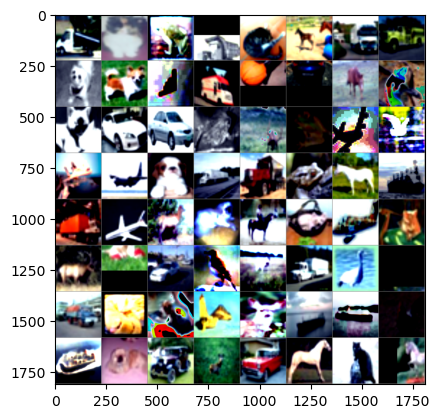

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# Model training

In [13]:
def metric_fn(y_pred, y_true):
    _, y_pred = torch.max(y_pred, 1)
    return accuracy_score(y_pred, y_true)

In [14]:
def train_model(model, dataloader, device, criterion, optimizer):
    model.train()
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        if out.size(1) == 1:
            # regression, squeeze output of shape [N,1] to [N]
            out = torch.squeeze(out, 1)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

In [15]:
def eval_model(model, dataloader, device, criterion=None):
    loss_value = []
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            if out.size(1) == 1:
                # regression, squeeze output of shape [N,1] to [N]
                out = torch.squeeze(out, 1)

            if criterion is not None:
                loss = criterion(out, yb)
                loss_value.append(loss.item())

            y_pred.append(out.detach().cpu())
            y_true.append(yb.detach().cpu())

    if criterion is not None:
        loss_value = sum(loss_value) / len(loss_value)
        return torch.cat(y_pred), torch.cat(y_true), loss_value
    else:
        return torch.cat(y_pred), torch.cat(y_true)

In [16]:
def run_experiment(dl_train,
                   dl_train_val,
                   dl_validation,
                   model,
                   optimizer,
                   criterion,
                   device,
                   max_epoch,
                   metric_fn,
                   init_epoch=0,
                   scheduler=None,
                   load_path=None,
                   save_path=None,
                   early_stopping=None,
                   ):
    results = {
        "train_loss": [],
        "valid_loss": [],
        "train_met": [],
        "valid_met": [],
        "state_dict": None,
    }

    best_validation_metric = .0
    model_best_state_dict = None
    no_score_improvement = 0
    experiment_start = datetime.now()

    if load_path is not None:
        # load full experiment state to continue experiment
        load_path = join(load_path, "full_state.pth")
        if not isfile(load_path):
            raise ValueError("Checkpoint file {} does not exist".format(load_path))

        checkpoint = torch.load(load_path)

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        model_best_state_dict = checkpoint['model_best_state_dict']
        model.load_state_dict(checkpoint['model_curr_state_dict'])

        init_epoch = checkpoint['epoch']
        best_validation_metric = checkpoint['best_validation_metric']

        if scheduler is not None:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        print("Successfully loaded checkpoint.")

    s = "Epoch/Max | Loss: Train / Validation | Metric: Train / Validation | Epoch time"
    print(s)

    if save_path is not None and not isdir(save_path):
        makedirs(save_path)
    for epoch in range(init_epoch, max_epoch):
        now = datetime.now()
        train_model(model=model,
                    dataloader=dl_train,
                    device=device,
                    criterion=criterion,
                    optimizer=optimizer, )

        # evaluate subset of train set (in eval mode)
        train_val_results = eval_model(model=model,
                                       dataloader=dl_train_val,
                                       device=device,
                                       criterion=criterion, )
        train_y_pred, train_y_true, train_loss = train_val_results
        train_metric = metric_fn(train_y_pred, train_y_true)
        results["train_loss"].append(train_loss)
        results["train_met"].append(train_metric)

        # evaluate validation subset
        valid_results = eval_model(model=model,
                                   dataloader=dl_validation,
                                   device=device,
                                   criterion=criterion, )
        valid_y_pred, valid_y_true, valid_loss = valid_results
        validation_metric = metric_fn(valid_y_pred, valid_y_true)
        results["valid_loss"].append(valid_loss)
        results["valid_met"].append(validation_metric)

        # check if validation score is improved
        if validation_metric > best_validation_metric:
            model_best_state_dict = deepcopy(model.state_dict())
            best_validation_metric = validation_metric
            # reset early stopping counter
            no_score_improvement = 0
            # save best model weights
            if save_path is not None:
                torch.save(model_best_state_dict, join(save_path, "best_weights.pth"))
        else:
            no_score_improvement += 1
            if early_stopping is not None and no_score_improvement >= early_stopping:
                print("Early stopping at epoch %d" % epoch)
                break

        if scheduler is not None:
            scheduler.step(validation_metric)

        if save_path is not None:
            # (optional) save model state dict at end of each epoch
            # torch.save(model.state_dict(), join(save_path, "model_state_{}.pth".format(epoch)))

            # save full experiment state at the end of each epoch
            checkpoint = {
                'epoch': epoch + 1,
                'model_curr_state_dict': model.state_dict(),
                'model_best_state_dict': model_best_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': None if scheduler is None else scheduler.state_dict(),
                'no_score_improvement': no_score_improvement,
                'best_validation_metric': best_validation_metric,
            }
            torch.save(checkpoint, join(save_path, "full_state.pth"))

        s = "{:>5}/{} | Loss: {:.4f} / {:.4f}".format(epoch, max_epoch, train_loss, valid_loss)
        s += " | Metric: {:.4f} / {:.4f}".format(train_metric, validation_metric)
        s += " | +{}".format(datetime.now() - now)
        print(s)

    print("Experiment time: {}".format(datetime.now() - experiment_start))
    return results

In [17]:
exp_results = run_experiment(
    dl_train=train_dataloader,
    dl_train_val=train_val_dataloader,
    dl_validation=val_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_epoch=max_epoch,
    metric_fn=metric_fn,
    scheduler=scheduler,
    load_path=None,
    save_path="./",
)

Epoch/Max | Loss: Train / Validation | Metric: Train / Validation | Epoch time
    0/30 | Loss: 1.6301 / 1.6215 | Metric: 0.4036 / 0.4025 | +0:13:26.942727
    1/30 | Loss: 0.9859 / 1.0150 | Metric: 0.6452 / 0.6382 | +0:13:38.911696
    2/30 | Loss: 0.7528 / 0.7995 | Metric: 0.7347 / 0.7169 | +0:13:39.184305
    3/30 | Loss: 0.6383 / 0.7097 | Metric: 0.7758 / 0.7510 | +0:13:39.441821
    4/30 | Loss: 0.5442 / 0.6437 | Metric: 0.8119 / 0.7807 | +0:13:38.353681
    5/30 | Loss: 0.4638 / 0.5827 | Metric: 0.8388 / 0.8016 | +0:13:38.570401
    6/30 | Loss: 0.3939 / 0.5336 | Metric: 0.8615 / 0.8180 | +0:13:37.492715
    7/30 | Loss: 0.3242 / 0.4698 | Metric: 0.8889 / 0.8402 | +0:13:38.160744
    8/30 | Loss: 0.3049 / 0.4677 | Metric: 0.8950 / 0.8419 | +0:13:38.491487
    9/30 | Loss: 0.2334 / 0.4190 | Metric: 0.9203 / 0.8570 | +0:13:40.114029
   10/30 | Loss: 0.2362 / 0.4397 | Metric: 0.9192 / 0.8551 | +0:13:49.859427
   11/30 | Loss: 0.1863 / 0.3968 | Metric: 0.9374 / 0.8656 | +0:13:49.7895

# Model Result

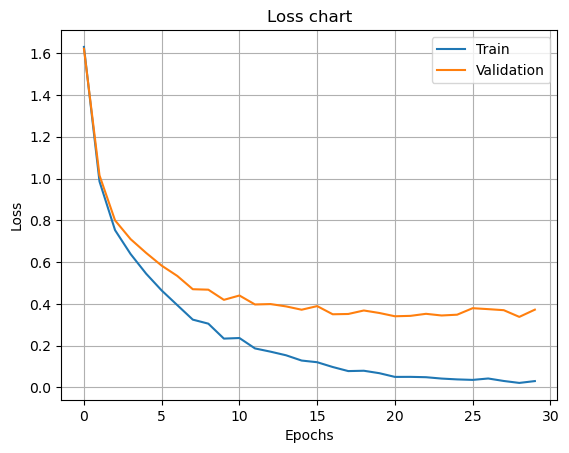

In [18]:
epochs = list(range(max_epoch))
train_loss = exp_results["train_loss"]
valid_loss = exp_results["valid_loss"]
lines = plt.plot(epochs, train_loss, epochs, valid_loss)

plt.legend(('Train', 'Validation'), loc='upper right')
plt.title('Loss chart')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

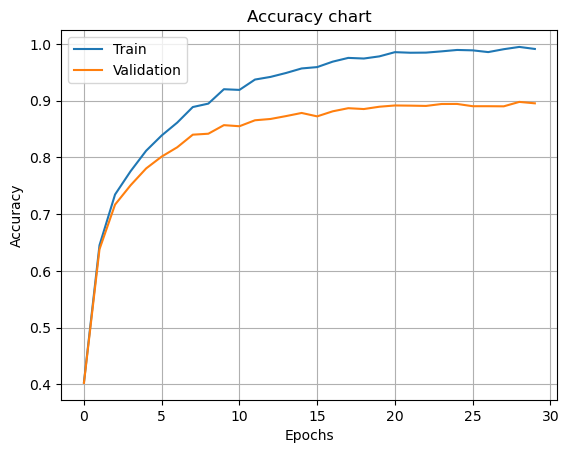

In [19]:
epochs = list(range(max_epoch))
train_metric = exp_results["train_met"]
valid_metric = exp_results["valid_met"]
lines = plt.plot(epochs, train_metric, epochs, valid_metric)

plt.legend(('Train', 'Validation'), loc='upper left')
plt.title('Accuracy chart')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()